# Whistle Detection with Continuous Kernel Convolutional Networks

In [1]:
from config import *
import os
from whistlenet.core.utils import project_root
import warnings
warnings.filterwarnings("ignore")

config_path = os.path.join(project_root(), "config","whistle_config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet

from config.enums import Optimizer

print(list(Optimizer))

/home/neverorfrog/code/whistle/whistlenet/.pixi/envs/default/lib/python3.9/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neverorfrog/code/whistle/whistlenet/.pixi/envs/default/lib/python3.9/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


[<Optimizer.ASGD: 'ASGD'>, <Optimizer.Adadelta: 'Adadelta'>, <Optimizer.Adagrad: 'Adagrad'>, <Optimizer.Adam: 'Adam'>, <Optimizer.AdamW: 'AdamW'>, <Optimizer.Adamax: 'Adamax'>, <Optimizer.LBFGS: 'LBFGS'>, <Optimizer.NAdam: 'NAdam'>, <Optimizer.Optimizer: 'Optimizer'>, <Optimizer.RAdam: 'RAdam'>, <Optimizer.RMSprop: 'RMSprop'>, <Optimizer.Rprop: 'Rprop'>, <Optimizer.SGD: 'SGD'>, <Optimizer.SparseAdam: 'SparseAdam'>]


In [2]:
import torch
import numpy as np
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

Dataset Preparation

DATA LOADED!

N Examples: 219862
N Classes: 2
Classes: [0. 1.]
 - Class 0: 109938 (50.00318381530232)
 - Class 1: 109924 (49.99681618469767)


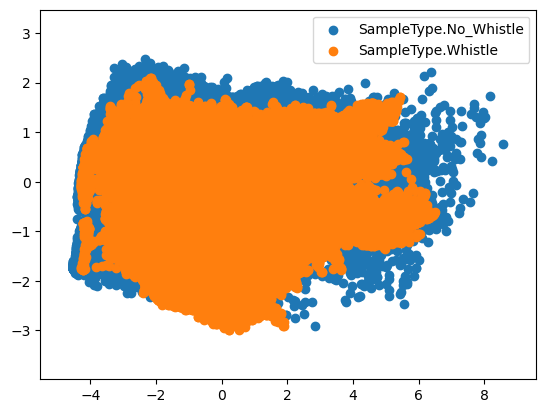

In [3]:
from whistlenet.data import WhistleDataset
from whistlenet.core.utils import plot, NUM_FREQS
from whistlenet.core.utils.audio import SampleType

dataset = WhistleDataset(dataset_config)
dataset.summarize()
reshaped = dataset.train_data.reshape((dataset.train_data.data.shape[0], NUM_FREQS))
plot(reshaped, dataset.train_data.labels, SampleType)

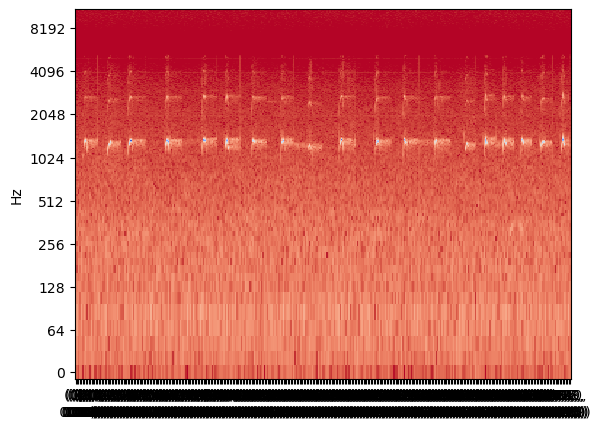

In [4]:
from whistlenet.core.utils import Audio, project_root
projroot = project_root()
audio = Audio(name="KronosTest_RC22", datapath=f'{projroot}/data/whistle/raw/train_cut', labelpath=f'{projroot}/data/whistle/labels/train_cut')
audio.freq_plot()

Model Training

In [5]:
from whistlenet.models import WhistleNet, Baseline
from whistlenet.core import LightningTrainer

model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
trainer = LightningTrainer(trainer_config)
# trainer.fit(model,dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Inference on test audio

In [6]:
import torch
import time
import lightning as L

audiolabels = audio.get_labels()
checkpoint_path = os.path.join(trainer_config.ckpt_path, "epoch=7-step=14376.ckpt")
model = WhistleNet.load_from_checkpoint(checkpoint_path, in_channels = 1, out_channels = 1, config=whistlenet_config)

def normalize(data: torch.Tensor, epsilon: float = 1e-6) -> torch.Tensor:
    min = data.min()
    max = data.max()
    data = (data - min) / (
        max - min + epsilon
    )  # Adding epsilon to avoid division by zero
    return data

def classify(window):
    with torch.inference_mode():
        start = time.time()
        confidence = model(window).item()
        print(f"Confidence: {confidence:.4f}")
        prediction = 1 if confidence > 0.5 else 0
        elapsed = time.time() - start
        print(f"Prediction: {prediction}, elapsed: {elapsed:.4f}")
        return prediction

FileNotFoundError: [Errno 2] No such file or directory: '/home/neverorfrog/code/whistle/whistlenet/whistlenet/scripts/ckpt/epoch=7-step=14376.ckpt'

In [9]:
for i in range(audio.frames):
    window = torch.from_numpy(audio.S[0,:,i].reshape(1,1,NUM_FREQS))
    window = normalize(window)
    print(f"frame {i}, time {audio.frame2time(i):.2f}")
    print(f"label: {audiolabels[0,i]}")
    classify(window)
    print()

frame 0, time 0.00
label: 0.0
Confidence: 0.3721
Prediction: 0, elapsed: 0.0085

frame 1, time 0.02
label: 0.0
Confidence: 0.4609
Prediction: 0, elapsed: 0.0029

frame 2, time 0.05
label: 0.0
Confidence: 0.3824
Prediction: 0, elapsed: 0.0022

frame 3, time 0.07
label: 0.0
Confidence: 0.5682
Prediction: 1, elapsed: 0.0018

frame 4, time 0.09
label: 0.0
Confidence: 0.5134
Prediction: 1, elapsed: 0.0014

frame 5, time 0.12
label: 0.0
Confidence: 0.4080
Prediction: 0, elapsed: 0.0014

frame 6, time 0.14
label: 1.0
Confidence: 0.5843
Prediction: 1, elapsed: 0.0014

frame 7, time 0.16
label: 1.0
Confidence: 0.5029
Prediction: 1, elapsed: 0.0017

frame 8, time 0.19
label: 0.0
Confidence: 0.4748
Prediction: 0, elapsed: 0.0018

frame 9, time 0.21
label: 0.0
Confidence: 0.5141
Prediction: 1, elapsed: 0.0013

frame 10, time 0.23
label: 0.0
Confidence: 0.4265
Prediction: 0, elapsed: 0.0013

frame 11, time 0.26
label: 0.0
Confidence: 0.4677
Prediction: 0, elapsed: 0.0013

frame 12, time 0.28
label:

## Export to ONNX

In [8]:
file = f"{projroot}/models/{model.name}/whistle.onnx"

torch.onnx.export(
    model,
    model.example_input[0],
    f = file,
    input_names=["input"],
    output_names=["output"],
)